알파코 said, 객체인식 프로젝트를 위해 아껴두라고 하니까, 이번 이미지 인식은 여기서 돌리지는 말고, 일단 코드 정리만 해두고 나중에 다른 계정으로 옮겨서 제출

## 1. 데이터 크롤링 (리소스 문제로 나눠 크롤링 & 리사이징 후 파일 취합)

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import re
import pickle
from bs4 import BeautifulSoup
import time
from io import BytesIO
import requests
from PIL import Image

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
page = 1
size_labels = ['medium']
size_url = [i.upper() for i in size_labels]
period_labels = ['2020', '2010', '2000', '1990', '1980', '1970', '1960', '1950', '1940', '1930', '1920', '1910', '1900']

In [ ]:
# 크롤링 코드
te1 = []
for period in tqdm(period_labels):
    for price_range_start in range(10000, 14000, 2000):
        price_range_end = price_range_start + 2000
        for page in range(1, 101):
            hab_url = f'https://www.artsy.net/collect?major_periods%5B0%5D={period}&page={page}&sizes%5B0%5D=MEDIUM&attribution_class%5B0%5D=unique&additional_gene_ids%5B0%5D=painting&price_range={price_range_start}-{price_range_end}'
            if 'page=1' in hab_url:
                hab_url = re.sub('page=1&', '', hab_url)
            res = requests.get(hab_url)
            print(hab_url)
            res.encoding = res.apparent_encoding
            time.sleep(1)
            four = BeautifulSoup(res.content, 'lxml')
            artwork_items = four.find_all('div', {'data-test': 'artworkGridItem'})
            tri = BeautifulSoup(res.content, 'lxml')
            tri_all_a = tri.find_all('a', {'class': 'Pagination__PageLink-sc-1r2jw01-0 btKriA'})
            if len(tri_all_a) > 0:
                n = tri_all_a[-1].text
            else:
                break
            if page > int(n):
                break
            for i in artwork_items:
                jagpumname = i.i.text
                jagga = i.img.get('alt').split(', ')[0]
                year = period+'s'
                price = i.find('div', {'class': 'Box-sc-15se88d-0 Text-sc-18gcpao-0 eXbAnU bfCidL'}).text[:-1]
                img_path = i.img.get('src')
                te1.append([jagpumname, jagga, 'medium', year, price, img_path])
frame2 = pd.DataFrame(te1)
frame2.drop_duplicates(5, inplace=True)
frame2.columns = ['title', 'artist', 'size', 'year', 'price', 'imgpath']
frame2.reset_index(inplace=True)
frame2.drop('index', axis=1, inplace=True)

with open('dataframe.pickle', 'wb') as file:
    pickle.dump(frame2, file)

##2. 데이터 EDA & 전처리

###2-1. 이미지 : 리사이징

In [ ]:
#url불러와서 리사이즈

def resize(im):

    res = requests.get(im)
    img = Image.open(BytesIO(res.content))
    img = np.array(img)

    img_size = 224

    if img.ndim != 3:  # 흑백 이미지인 경우
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if(img.shape[1] > img.shape[0]) :
        ratio = img_size/img.shape[1]
    else :
        ratio = img_size/img.shape[0]

    img = cv2.resize(img, dsize=(0, 0), fx=ratio, fy=ratio, interpolation=cv2.INTER_LINEAR)

    # 그림 주변에 검은색으로 칠하기
    w, h = img.shape[1], img.shape[0]

    dw = (img_size-w)/2 # img_size와 w의 차이
    dh = (img_size-h)/2 # img_size와 h의 차이

    M = np.float32([[1,0,dw], [0,1,dh]])  #(2*3 이차원 행렬)
    img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환

    return img_re

####Resized 파일 취합

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path_1 = '/content/drive/MyDrive/resized_6000to10000.pkl'
df_1 = pd.read_pickle(file_path_1)

In [ ]:
df_1.info()   # 1.6만 건

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16293 entries, 0 to 16292
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    16293 non-null  object
 1   artist   16293 non-null  object
 2   size     16293 non-null  object
 3   year     16293 non-null  object
 4   price    16293 non-null  object
 5   imgpath  16293 non-null  object
 6   reimg    16293 non-null  object
dtypes: object(7)
memory usage: 891.1+ KB


In [ ]:
file_path_2 = '/content/drive/MyDrive/resized_10000to14000.pkl'
df_2 = pd.read_pickle(file_path_2)

In [ ]:
df_2.info() # 1.2만 건

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11985 entries, 0 to 11984
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    11985 non-null  object
 1   artist   11985 non-null  object
 2   size     11985 non-null  object
 3   year     11985 non-null  object
 4   price    11985 non-null  object
 5   imgpath  11985 non-null  object
 6   resize   11985 non-null  object
dtypes: object(7)
memory usage: 655.6+ KB


In [ ]:
# Concatenate the DataFrames vertically
concatenated_df = pd.concat([df_1, df_2], ignore_index=True)

In [ ]:
output_file_path = '/content/drive/MyDrive/resized_6kto14k.pickle'
concatenated_df.to_pickle(output_file_path)

In [ ]:
df = pd.read_pickle(output_file_path)

In [ ]:
df.info() # 2.8만 건

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28278 entries, 0 to 28277
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    28278 non-null  object
 1   artist   28278 non-null  object
 2   size     28278 non-null  object
 3   year     28278 non-null  object
 4   price    28278 non-null  object
 5   imgpath  28278 non-null  object
 6   reimg    16293 non-null  object
 7   resize   11985 non-null  object
dtypes: object(8)
memory usage: 1.7+ MB


In [ ]:
# 소액 작품 추가 취합 (용량, 리소스 등 문제로 다른 Colab에서 돌림)
file_path_3 = '/content/drive/MyDrive/priced_100to6000.pkl'
df_3 = pd.read_pickle(file_path_3)

In [ ]:
# Concatenate the DataFrames vertically
concatenated_df = pd.concat([df, df_3], ignore_index=True)

In [ ]:
output_file_path = '/content/drive/MyDrive/resized_6kto14k.pickle'
concatenated_df.to_pickle(output_file_path)

In [ ]:
df = pd.read_pickle(output_file_path)

In [ ]:
df.info() # 4.9만 건 (price = $100 - 14k, "others" 삭제)

###2-2. 가격 :

In [ ]:
# Extract numeric values and units into new columns 가격 '단위'와 '금액' 분리
df[['unit', 'price_value']] = df['price'].str.extract(r'([^\d,.]+)?([0-9,.]*)')

# Remove commas from the 'price_value' column
df['price_value'] = df['price_value'].str.replace(',', '')

# Convert 'price_value' to numeric, treating empty strings as NaN
df['price_value'] = pd.to_numeric(df['price_value'], errors='coerce')

In [ ]:
# 통화 단위(unit) EDA
unique_units = df['unit'].unique()
print(unique_units)

['US$' '£' '€' 'CN¥' 'AU$' 'Price on request' 'ZAR R' 'C$' 'HK$' 'S$'
 'JPY ¥' 'NT$' 'INR ₹' 'DKK' 'Sold' 'On loan' '\xa0' 'On hold' 'CHF'
 'BRL R$' 'COP$' 'KRW ₩' 'Permanent collection']


In [ ]:
unit_counts = df['unit'].value_counts()
print(unit_counts)

US$                     14107
Price on request         5540
€                        3648
Sold                     2269
£                        1644
                          656
C$                        102
AU$                        56
HK$                        44
KRW ₩                      42
On loan                    24
On hold                    23
INR ₹                      23
CHF                        22
BRL R$                     17
NT$                        14
S$                         11
CN¥                        10
JPY ¥                       8
COP$                        7
ZAR R                       6
DKK                         4
Permanent collection        1
Name: unit, dtype: int64


결측치 & 이상치 처리 ($6k-14k 기준: 8,513건, $100-6k 기준: 약 4천 건)
* unit: 'Price on request', 'Sold', '\xa0', 'On hold', 'On loan', 'Permanent collection' => 'Others' 처리 후 삭제

In [ ]:
rows_empty = df[df['unit'] == '\xa0']
print("Rows where 'unit' is empty':\n", rows_empty) # 가격 결측치 656 건

In [ ]:
# Values to be replaced in the 'unit' column
values_to_replace = ['Price on request', 'Sold', '\xa0', 'On hold', 'On loan', 'Permanent collection']

# Replace values in the 'unit' column with 'others'
df['unit'] = df['unit'].replace(values_to_replace, 'others')

In [ ]:
# Filter rows where 'unit' column has the value 'others'
rows_others = df[df['unit'] == 'others']
print("Number of rows where 'unit' is 'others':", rows_others.shape[0])

Number of rows where 'unit' is 'others': 8513


*  Under US$, Under £, Under € 1,000 -> 편의상 1000로 처리

In [ ]:
filtered_unit = df[df['unit'].isin(['Under US$', 'Under £', 'Under €'])]
print(filtered_unit[['price', 'unit', 'price_value']])

In [ ]:
replace_dict = {'Under US$': 'US$', 'Under £': '£', 'Under €': '€'}
df['unit'] = df['unit'].replace(replace_dict)

####US$ 기준으로 환전

In [ ]:
# 통화 별, US$에 곱해줘야 할 적용 환율 => 이제 가격은 'price_usd' 컬럼만 보면 됩니다
# € 유로 * 1.09
# £ 영국 파운드 * 1.27
# AU$ 호주 달러 * 0.66
# CHF 스위스 프랑 * 1.15
# C$ 캐나다 달러 * 0.74
# S$ 싱가폴 달러 * 0.75
# KRW ₩ 한국 원  * 0.00075
# HK$ 홍콩 달러 * 0.13
# INR ₹ 인도 루피 * 0.012
# CN¥ 중국 위안 * 0.14
# NT$ 대만 달러 * 0.032
# COP$ 콜롬비아 페소 * 0.00026
# DKK 덴마크 크로네 * 0.15
# ZAR R 남아공 랜드 * 0.053
# BRL R$ 브라질 헤알 * 0.20
# JPY ¥ 일본 엔 * 0.0068

In [ ]:
# Convert 'price_value' to numeric, treating non-convertible values as NaN
df['price_usd'] = pd.to_numeric(df['price_value'], errors='coerce')

# Fill NaN values with a default value (e.g., 0)
df['price_usd'].fillna(0, inplace=True)

# Apply conversion rates based on the unit
df.loc[df['unit'] == '€', 'price_usd'] *= 1.09
df['price_usd'] = df['price_usd'].round().astype(int)
df.loc[df['unit'] == '£', 'price_usd'] *= 1.27
df.loc[df['unit'] == 'AU$', 'price_usd'] *= 0.66
df.loc[df['unit'] == 'CHF', 'price_usd'] *= 1.15
df.loc[df['unit'] == 'C$', 'price_usd'] *= 0.74
df.loc[df['unit'] == 'S$', 'price_usd'] *= 0.75
df.loc[df['unit'] == 'KRW ₩', 'price_usd'] *= 0.00075
df.loc[df['unit'] == 'HK$', 'price_usd'] *= 0.13
df.loc[df['unit'] == 'INR ₹', 'price_usd'] *= 0.012
df.loc[df['unit'] == 'CN¥', 'price_usd'] *= 0.14
df.loc[df['unit'] == 'NT$', 'price_usd'] *= 0.032
df.loc[df['unit'] == 'COP$', 'price_usd'] *= 0.00026
df.loc[df['unit'] == 'DKK', 'price_usd'] *= 0.15
df.loc[df['unit'] == 'ZAR R', 'price_usd'] *= 0.053
df.loc[df['unit'] == 'BRL R$', 'price_usd'] *= 0.20
df.loc[df['unit'] == 'JPY ¥', 'price_usd'] *= 0.0068

# Round 'price_usd' and convert it to integers
df['price_usd'] = df['price_usd'].round().astype(int)

In [ ]:
cols_to_check = ['price', 'unit', 'price_usd']
print(df[cols_to_check].head(30))

                price unit  price_usd
0            US$7,000  US$       7000
1            US$7,000  US$       7000
2              £6,000    £       7620
3            US$6,800  US$       6800
4              £6,000    £       7620
5              £6,000    £       7620
6            US$6,800  US$       6800
7   US$4,500–US$7,000  US$       4500
8            US$7,000  US$       7000
9            US$7,500  US$       7500
10             £6,000    £       7620
11           US$7,000  US$       7000
12           US$7,000  US$       7000
13           US$6,000  US$       6000
14           US$8,000  US$       8000
15           US$7,000  US$       7000
16             £6,000    £       7620
17             £6,000    £       7620
18           US$8,000  US$       8000
19           US$8,000  US$       8000
20             €6,900    €       7521
21             £6,000    £       7620
22             €5,950    €       6486
23           US$7,100  US$       7100
24           US$7,000  US$       7000
25          

In [ ]:
# Remove rows where 'unit' is 'others'
df_price = df[df['unit'] != 'others']

# Save the DataFrame as a new pickle file
output_price_file_path = '/content/drive/MyDrive/df_price.pickle'
df_price.to_pickle(output_price_file_path)

In [ ]:
df_price = pd.read_pickle(output_price_file_path)

In [ ]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19765 entries, 0 to 28276
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        19765 non-null  object 
 1   artist       19765 non-null  object 
 2   size         19765 non-null  object 
 3   year         19765 non-null  object 
 4   price        19765 non-null  object 
 5   imgpath      19765 non-null  object 
 6   reimg        13465 non-null  object 
 7   resize       6300 non-null   object 
 8   unit         19765 non-null  object 
 9   price_value  19765 non-null  float64
 10  price_usd    19765 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 1.8+ MB


In [ ]:
y = df['price_usd'].astype(np.float32)
y = np.array(y)
y = y.reshape(-1, 1)

scaler = StandardScaler()
price_scaler = scaler.fit_transform(y)

###2-3. 기간 :

In [ ]:
# Count occurrences of unique values in the 'year' column -> 1910s 데이터 크롤링 누락
year_counts = df_price['year'].value_counts()
print("Counts by year:\n", year_counts)

Counts by year:
 2020s    8714
2010s    6342
2000s    1821
1990s     711
1980s     529
1960s     400
1970s     388
1950s     311
1940s     165
1930s     165
1920s     113
1900s     106
Name: year, dtype: int64


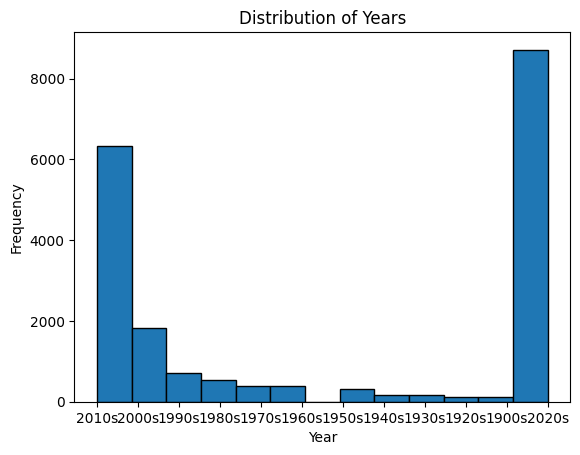

In [ ]:
# Plot the histogram for the DataFrame
import matplotlib.pyplot as plt
plt.hist(df_price['year'], bins=13, edgecolor='black')
plt.title('Distribution of Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

In [ ]:
replace_dict = {"1940s": "1950s 이전", "1930s": "1950s 이전", "1920s": "1950s 이전", "1910s": "1950s 이전", "1900s": "1950s 이전", 'Before 1950s 이전': "1950s 이전"}

df_price['year'] = df_price['year'].replace(replace_dict)

In [ ]:
year_encoder = OneHotEncoder()

year_d = year_encoder.fit_transform(df_price[['year']])

###2-4. 작가 :

In [ ]:
unique_artists_count = df_price['artist'].nunique()
print("Number of unique artists:", unique_artists_count)

# Count occurrences of unique values in the 'artist' column
artist_counts = df_price['artist'].value_counts()
print("Counts by artist:\n", artist_counts)

Number of unique artists: 6464
Counts by artist:
 Anand Manchiraju      109
Hunt Slonem            89
Simon Bull             65
J. Steven Manolis      65
Soile Yli-Mäyry        45
                     ... 
Arthur Sarnoff          1
Javier Vilato           1
Robert W. Douglass      1
Paul Burckhardt         1
Thomas Baker            1
Name: artist, Length: 6464, dtype: int64


In [ ]:
# Filter for artists with counts greater than 30
filtered_artists = artist_counts[artist_counts > 25]
print("Top 20 artists or those with counts > 25:\n", filtered_artists.head(50))

Top 20 artists or those with counts > 25:
 Anand Manchiraju             109
Hunt Slonem                   89
Simon Bull                    65
J. Steven Manolis             65
Soile Yli-Mäyry               45
Carson Ferri-Grant            45
Jimi Gleason                  44
Sori Choi                     44
Carlos Gamez de Francisco     42
Clive McCartney               41
Rainer Gross                  38
Dimitri Likissas              37
Antonio Feltrinelli           35
Robert Standish               35
Howard Danelowitz             34
Bekah Bull                    34
Thierry Lefort                33
Adam Straus                   32
Kurz                          32
Kim Frohsin                   31
Poul Webb                     31
Alain Clément                 31
Derek Balmer                  29
John Virtue                   29
Denis Bowen                   29
Susannah Phillips             29
Ellen Liman                   28
Beatrice Mandelman            28
John Zinsser                  28


In [ ]:
artist_encoder = OneHotEncoder()

artist_d = artist_encoder.fit_transform(df_price[['year']])

In [ ]:
from scipy.sparse import hstack

meta_x = hstack((artist_d, year_d))

x_tr, x_val, y_tr, y_val = train_test_split(meta_x, y, random_state = 1001, test_size = 0.2)

##3. 모델링

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import r2_score

dir(tf.keras.applications)

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import vgg19

from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Concatenate
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
resnet = ResNet50(include_top = False, input_shape = (224,224,3), weights = 'imagenet')
inception = InceptionV3(include_top = False, input_shape = (224,224,3), weights = 'imagenet')
vgg = vgg19.VGG19(include_top = False, input_shape = (224,224,3), weights = 'imagenet')

In [ ]:
resnet.trainable = False
inception.trainable = False
vgg.trainable = False

In [ ]:
resnet.output_shape, inception.output_shape, vgg.output_shape

In [ ]:
with open('data_cnn.pickle', 'rb') as file:
    data_cnn = pickle.load(file)
data_cnn

In [ ]:
image_df = data_cnn[['resize', 'price_usd']]
image_df

In [ ]:
# 'price_usd' 열에 대해서 Z-score 계산
z_scores = zscore(image_df['price_usd'])

# Z-score가 특정 임계값 이상인 데이터 포인트 확인
threshold = 1  # 예시로 임계값을 3으로 설정
outliers_indices = (z_scores < -threshold) | (z_scores > threshold)

outliers_indices.sum()

In [ ]:
image_df = image_df[~outliers_indices]

In [ ]:
x = np.stack(image_df['resize'].values)
y = image_df['price_usd'].astype(np.float32)
y = y.values.reshape(-1, 1)
scaler = StandardScaler()
y_norm = scaler.fit_transform(y) # price scale
joblib.dump(scaler, 'price_scaler.pkl') # scaler 저장
x_train, x_val, y_train, y_val = train_test_split(x, y_norm, random_state = 1001, test_size = 0.2)

###3-1. ResNet

In [ ]:
inputs = Input(shape = (224,224,3))
x = resnet(inputs, training = False)
x = Flatten(input_shape = resnet.output_shape[1:])(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation = 'linear')(x)

resnet_model = tf.keras.Model(inputs, outputs)

In [ ]:
resnet_model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
resnet_model.compile(optimizer = optimizer, loss = 'mse', metrics = ['RootMeanSquaredError', 'R2Score'])

In [ ]:
resnet_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks = [early_stopping])

###3-2. Inception

In [ ]:
inputs = Input(shape = (224,224,3))
x = inception(inputs, training = False)
x = Flatten(input_shape = resnet.output_shape[1:])(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation = 'linear')(x)

inception_model = tf.keras.Model(inputs, outputs)

In [ ]:
inception_model.summary()

In [ ]:
inception_model.compile(optimizer = 'Adam', loss = 'mse', metrics = ['RootMeanSquaredError', 'R2Score'])

In [ ]:
inception_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks = [early_stopping])

###3-3. VGG

In [ ]:
inputs = Input(shape = (224,224,3))
x = vgg(inputs, training = False)
x = Flatten(input_shape = resnet.output_shape[1:])(x)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.5)(x)
outputs =  Dense(1, activation = 'linear')(x)

vgg_model = tf.keras.Model(inputs, outputs)

In [ ]:
vgg_model.summary()

In [ ]:
vgg_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['RootMeanSquaredError', 'R2Score'])

In [ ]:
vgg_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), callbacks = [early_stopping])

In [ ]:
resnet_model.save('resnet_model.h5')
inception_model.save('inception_model.h5')
vgg_model.save('vgg_model.h5')

###3-4. Regression

In [ ]:
inputs = Input(shape = (20)) # input shape 넣을것
x = Dense(16, activation = 'relu')(inputs)
outputs = Dense(1, activation = 'linear')(x)

reg_model = tf.keras.Model(inputs, outputs)

In [ ]:
reg_model.compile(optimizer = 'adam', loss = 'rmse', metrics = ['rmse', 'r_square'])

###3-5. 융합

In [ ]:
with open('meta_x_train_final.pkl', 'rb') as file:
    meta_x_train = pickle.load(file)

with open('meta_x_val_final.pkl', 'rb') as file:
    meta_x_val = pickle.load(file)

with open('img_y_train_final.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('img_y_val_final.pkl', 'rb') as file:
    y_val = pickle.load(file)

with open('img_x_train_final.pkl', 'rb') as file:
    img_x_train = pickle.load(file)

with open('img_x_val_final.pkl', 'rb') as file:
    img_x_val = pickle.load(file)

In [ ]:
from tensorflow.keras.models import load_model

# VGG 모델 로드
vgg_model = tf.keras.models.load_model('vgg_model.h5', compile=False)
# ResNet 모델 로드
resnet_model = tf.keras.models.load_model('resnet_model.h5', compile=False)
# Inception 모델 로드
inception_model = tf.keras.models.load_model('inception_model.h5', compile=False)
# reg_model 모델 로드
reg_model = tf.keras.models.load_model('reg_model.h5', compile=False)

In [ ]:
resnet_model = tf.keras.Model(inputs=resnet_model.inputs, outputs=resnet_model.outputs, name='resnet_model')
inception_model = tf.keras.Model(inputs=inception_model.inputs, outputs=inception_model.outputs, name='inception_model')
vgg_model = tf.keras.Model(inputs=vgg_model.inputs, outputs=vgg_model.outputs, name='vgg_model')
reg_model = tf.keras.Model(inputs=reg_model.inputs, outputs=reg_model.outputs, name='reg_model')

In [ ]:
resnet_model.trainable = False
inception_model.trainable = False
vgg_model.trainable = False
reg_model.trainable = False

In [ ]:
reg_input = meta_x_train.shape[1]

inputs = Input(shape = (224,224,3), name='image_input')
reg_input = Input(shape = (reg_input), name='reg_input')
x1 = resnet_model(inputs, training=False)
x2 = inception_model(inputs, training=False)
x3 = vgg_model(inputs, training=False)
x4 = reg_model(reg_input, training=False)
concat = Concatenate()([x1, x2, x3, x4])
outputs = Dense(1, activation, ='linear')(concat)

final_model = tf.keras.Model(inputs=[inputs, reg_input], outputs=outputs)

In [ ]:
final_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['RootMeanSquaredError', 'R2Score'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
final_model.fit([img_x_train, meta_x_train], y_train, epochs = 100, batch_size = 1000, callbacks = [es], validation_data = ([img_x_val, meta_x_val], y_val))